# Sign spotting
This notebook trains the sign spotting model. We load in the data, split it into positive pairs (two data points of the same sign) and make batches using these pairs. After training the model, we create reference embeddings based on the train embeddings, where we average the 10% most representative train embeddings (those closest, on average, to all other train embeddings of the same sign) for each target sign to create that sign's reference. 

**Important note:** this notebook has to be run *twice*, once with `only_lmrks = True` and once with `only_lmrks = False`. 

In [1]:
# imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Hides info/warning TF messages after this code block

from tensorflow import keras
from keras.optimizers import Adam

import importlib

# Keep python tools up to date
from tools import tools, create_model, constants, sign_spot_tools
importlib.reload(tools)
importlib.reload(create_model)
importlib.reload(constants)
importlib.reload(sign_spot_tools)

# Import all functions from the tools
from tools.tools import load_dict, store_dict, ms_to_frame, sec_to_timestamp, frame_to_timestamp, print_stats
from tools.create_model import SupCon_loss, create_encoder
from tools.constants import PATHS # Path constants
from tools.sign_spot_tools import*

import numpy as np
from scipy.spatial.distance import cdist
from collections import Counter
import pandas as pd

# Set a numpy seed for consistent results
np.random.seed(123)

In [2]:
%%time
only_lmrks = True
mirror_aug = True
X_train, y_train, X_train_no_mirr, y_train_no_mirr, X_val, y_val, X_test, y_test, top = get_data(only_lmrks, #norm = True,
                                                                                                 rand_aug = False)
# Compute how many unique classes there are
num_classes = len(set(y_train.tolist() + y_val.tolist() + y_test.tolist()))
print('\nNumber of classes (unique signs) in data:', num_classes)

----------------------------------------------------------------------------------------------------
Train shape:		(180432, 10, 84)	Val shape:	(10295, 10, 84)	Test shape:	(9585, 10, 84)
Train label:		(180432,)		Val label:	(10295,)	Test label:	(9585,)
W/o augmentation:	(90216, 10, 84)	labels:	(90216,)

Number of classes (unique signs) in data: 2712
CPU times: total: 5.69 s
Wall time: 20.5 s


In [3]:
# We use the training data without mirror augmentation if mirror_aug = False
if not mirror_aug:
    X_train = X_train_no_mirr
    y_train = y_train_no_mirr

In [4]:
# Shuffle the training data using indices
train_shuffle = np.random.choice(np.arange(y_train.shape[0]), y_train.shape[0], replace = False)
X_train, y_train = X_train[train_shuffle], y_train[train_shuffle]

In [5]:
# Getting an idea of which glosses are most common in the annotations
# Load in the (integer) labels with their gloss counterparts
label_path = PATHS['label_encoder'].format(top)
labels = load_dict(label_path)

# Count train labels, sort in desc. order (most common first) then select top 25 labels
top_items = sorted(Counter(y_train).items(), key = lambda x: x[-1], reverse = True)[:25]

# The items are in the form (label, count) so we keep only the labels for now
top_labels = [x[0] for x in top_items]

# This matches the integer labels from the encoder to the top (integer) labels
target_labels = [x for x in labels.items() if x[1] in top_labels]

# We now grab the string equivalent of the integer labels, and get their frequency
fused = []
for target in target_labels:
    for item in top_items:
        int_label, count = item
        str_label, int_label_ = target
        if int_label == int_label_:
            fused.append((str_label, str(int_label), count))

# Prints triples of (gloss_name, gloss_integer_id, count)
print('Most common glosses as triple (string label, integer label, count)')
print(sorted(fused, key = lambda x: x[-1], reverse = True))

Most common glosses as triple (string label, integer label, count)
[('PT-1hand', '1993', 22896), ('PO', '1941', 17350), ('PT-1hand:1', '1994', 13514), ('GEBAREN-A', '828', 2552), ('PO+PT', '1942', 1902), ('GOED-A', '914', 1664), ('KUNNEN-A', '1335', 1520), ('HOREN-A', '1097', 1504), ('ATTENTIE', '222', 1496), ('WETEN-A', '2770', 1470), ('ZELFDE-A', '2824', 1320), ('ZIEN-A', '2857', 1226), ('1-A', '27', 1160), ('DOOF-A', '617', 1130), ('ZEGGEN', '2821', 1100), ('ZELF-A', '2822', 1092), ('NIET-A', '1641', 1042), ('HEE', '1028', 1032), ('GAAN-NAAR-A', '821', 1022), ('NU-A', '1671', 930), ('MOETEN-A', '1547', 922), ('KIJKEN-A', '1241', 828), ('HEBBEN-A', '1024', 808), ('LAAT-MAAR', '1350', 780), ('DOOF-B', '618', 778)]


# Creating batches

In [6]:
# Label frequencies within y_train
print(list(sorted(set(Counter(y_train).values()))))

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 210, 212, 214, 216, 220, 224, 226, 228, 234, 240, 242, 244, 248, 254, 256, 260, 262, 264, 266, 268, 270, 272, 280, 288, 290, 292, 294, 300, 304, 308, 318, 320, 324, 326, 336, 342, 344, 350, 354, 360, 366, 368, 372, 374, 376, 378, 386, 388, 400, 410, 416, 418, 420, 424, 432, 446, 452, 458, 466, 472, 474, 476, 480, 482, 484, 488, 504, 514, 518, 532, 534, 540, 546, 556, 558, 584, 588, 600, 614, 618, 652, 678, 684, 726, 736, 772, 778, 780, 808, 828, 922, 930, 1022, 1032, 1042, 1092, 1100, 1130, 1160, 1226, 1320, 1470, 1496, 1504, 1520, 1664

In [7]:
batch_size = 128
# window size aka how many instances of the same label/sign to group together
# ws = 2 is equal to making pairs of 2
ws = 4

# Make a batch generator for the training, validation data
train_batch_gen = positive_pairs_batch_gen(X_train, y_train, batch_size = batch_size, window_size = ws)
val_batch_gen = positive_pairs_batch_gen(X_val, y_val, batch_size = batch_size, window_size = ws)

Number of batches: 1410
Label frequencies in the batches: [(2, 2387), (4, 28658), (6, 131), (8, 1859), (10, 91), (12, 903), (14, 91), (16, 650), (18, 73), (20, 411), (22, 38), (24, 230), (26, 17), (28, 98), (30, 11), (32, 38), (34, 6), (36, 21), (40, 7), (42, 1), (44, 1)]


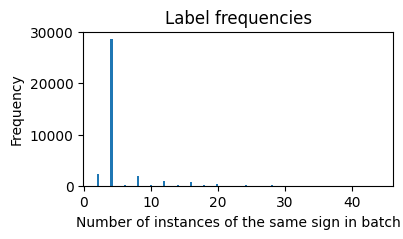

In [8]:
# Checking label counts for each batch, to see if there's no extremely dominant labels
# So we check how frequent each sign is per batch
i = 0
counts = []
for x_batch, y_batch in train_batch_gen:
    y_inds = []
    for y in y_batch.numpy():
        y_inds.append(y)
    # Getting non-duplicate, sorted label counts
    count = sorted(list(Counter(np.array(y_inds)).values()))
    counts += count
    i+=1

print('Number of batches:', i)
print('Label frequencies in the batches:', sorted(Counter(counts).items(), key = lambda x: x[0]))
plt.figure(figsize=(4,2))
plt.hist(counts, bins = batch_size)
plt.xlabel('Number of instances of the same sign in batch')
plt.ylabel('Frequency')
plt.title('Label frequencies')
plt.show()

In [9]:
# We pick a common sign here to see some plots of its embeddings similarity later
labels = load_dict(label_path)
target_num_label = labels['GEBAREN-A']
target_label = find_target_label(target_num_label, labels)

# Creating and training model

In [10]:
# Setting some parameters
temperature = 0.07
learning_rate = 0.001
input_shape = X_train[0].shape
bidirectional = True
masking = True #not only_lmrks

# Add None to dims if first layer is bi-LSTM (requires specific shape)
if bidirectional and not masking:
    input_shape = (None,) + input_shape

print('Input shape:', input_shape)
# Instantiating the model
model = create_encoder(input_shape, bidirectional, masking, dropout = 0, lstm_dropout = False,
                       num_dense = 2, dense_size = 256, num_lstm = 1, lstm_size = 128, bn = True)
model.build(input_shape)
model.summary()

Input shape: (10, 84)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 10, 84)            0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 10, 84)           0         
 se)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 256)              218112    
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                  

Epoch 1
1410/1410 [==============================] - 52s 26ms/step - loss: 0.6078 - val_loss: 0.5446
Ratio of randomly selected negative pairs >= 0.5: 0.009
Ratio of randomly selected positive pairs <= 0.5: 1.0
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


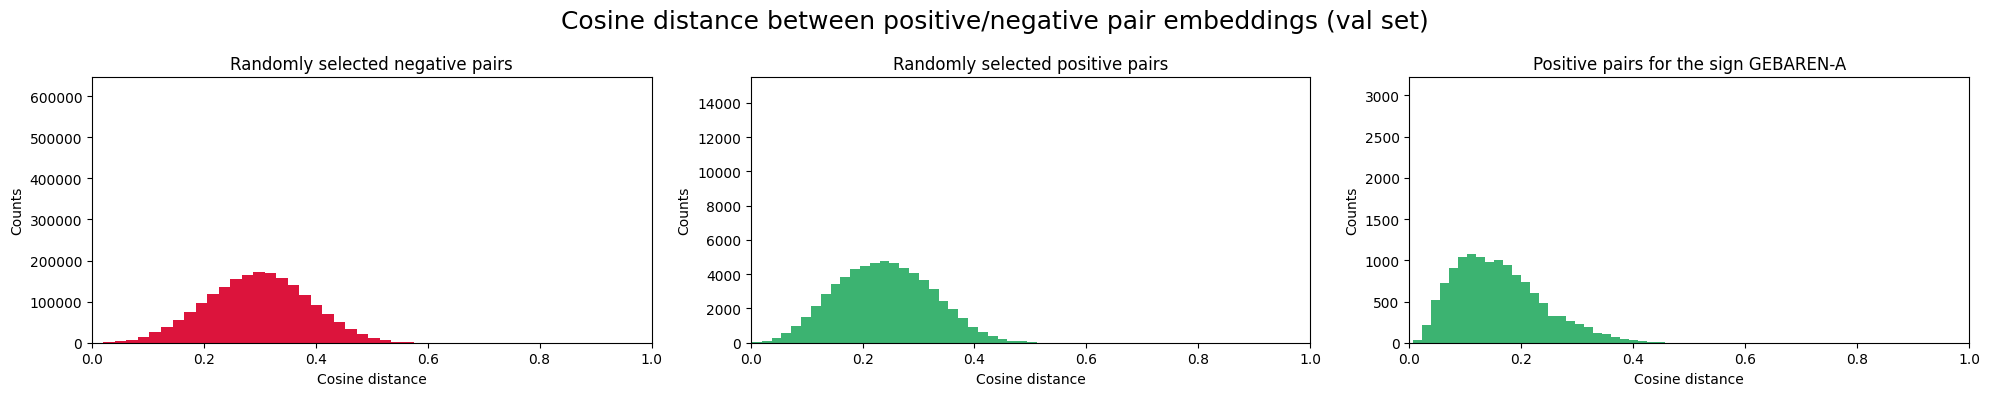

Epoch 2
1410/1410 [==============================] - 36s 21ms/step - loss: 0.5575 - val_loss: 0.5304
Ratio of randomly selected negative pairs >= 0.5: 0.006
Ratio of randomly selected positive pairs <= 0.5: 1.0
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


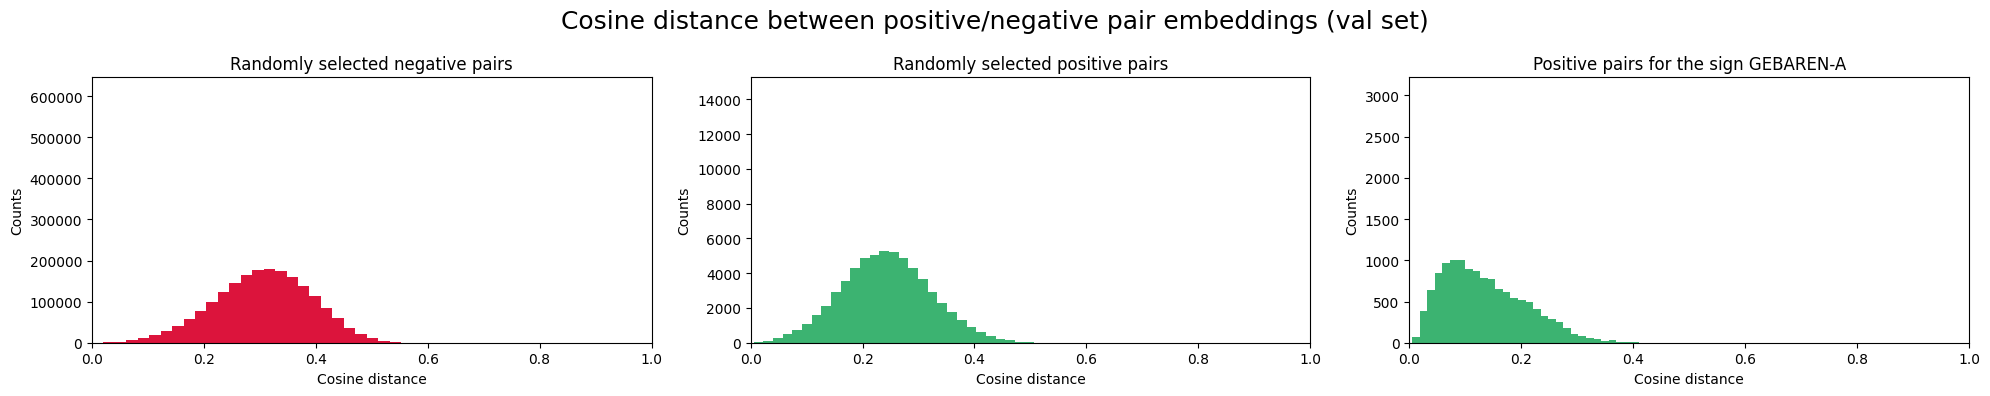

Epoch 3
1410/1410 [==============================] - 35s 21ms/step - loss: 0.5466 - val_loss: 0.5139
Ratio of randomly selected negative pairs >= 0.5: 0.015
Ratio of randomly selected positive pairs <= 0.5: 0.999
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


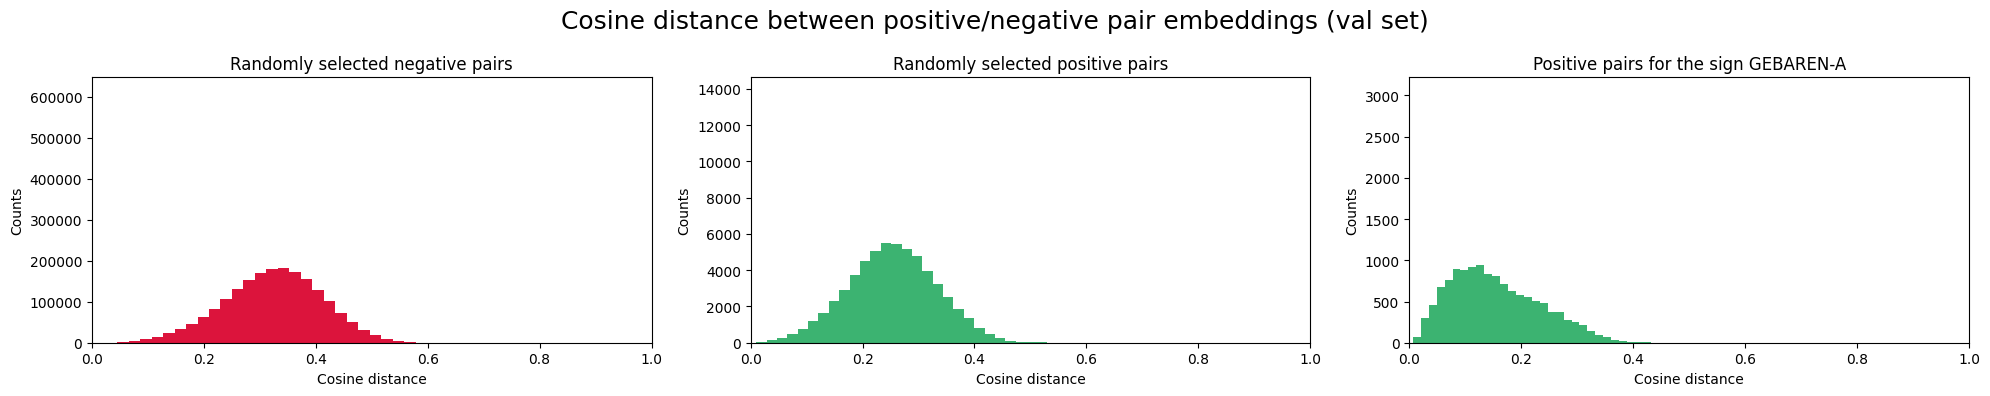

Epoch 4
1410/1410 [==============================] - 35s 21ms/step - loss: 0.5350 - val_loss: 0.5097
Ratio of randomly selected negative pairs >= 0.5: 0.017
Ratio of randomly selected positive pairs <= 0.5: 0.998
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


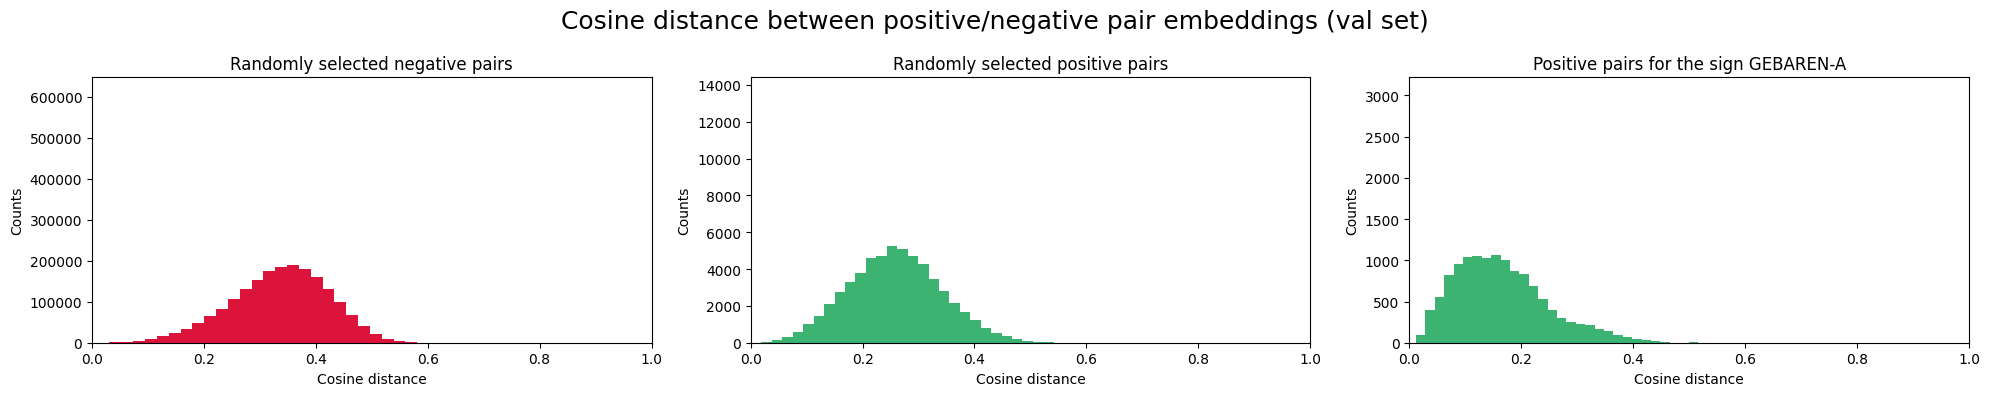

Epoch 5
1410/1410 [==============================] - 35s 21ms/step - loss: 0.5272 - val_loss: 0.5087
Ratio of randomly selected negative pairs >= 0.5: 0.052
Ratio of randomly selected positive pairs <= 0.5: 0.996
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


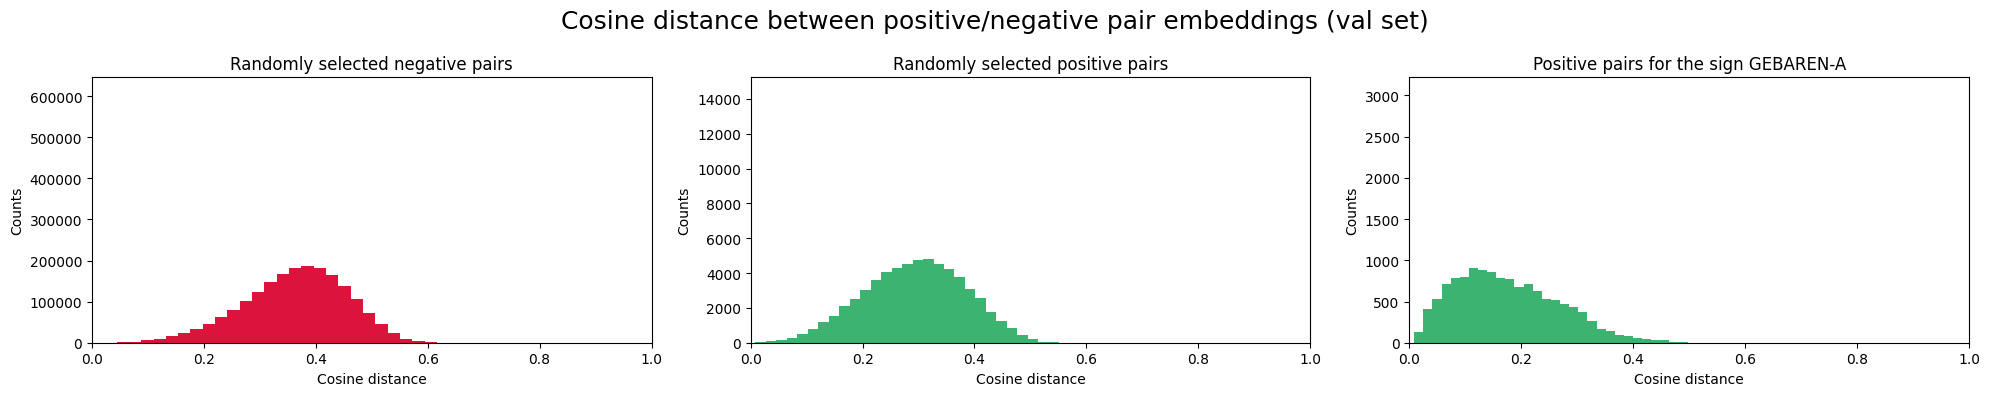

Epoch 6
1410/1410 [==============================] - 36s 21ms/step - loss: 0.5200 - val_loss: 0.5017
Ratio of randomly selected negative pairs >= 0.5: 0.083
Ratio of randomly selected positive pairs <= 0.5: 0.993
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


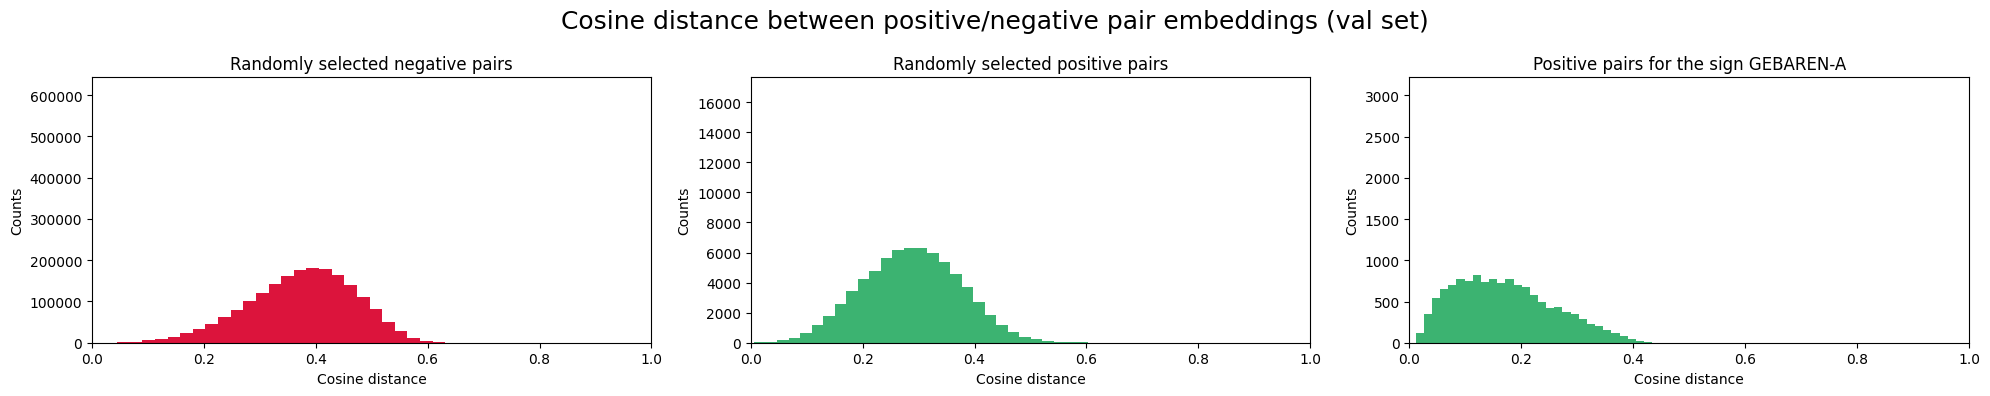

Epoch 7
1410/1410 [==============================] - 35s 21ms/step - loss: 0.5131 - val_loss: 0.4981
Ratio of randomly selected negative pairs >= 0.5: 0.097
Ratio of randomly selected positive pairs <= 0.5: 0.99
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


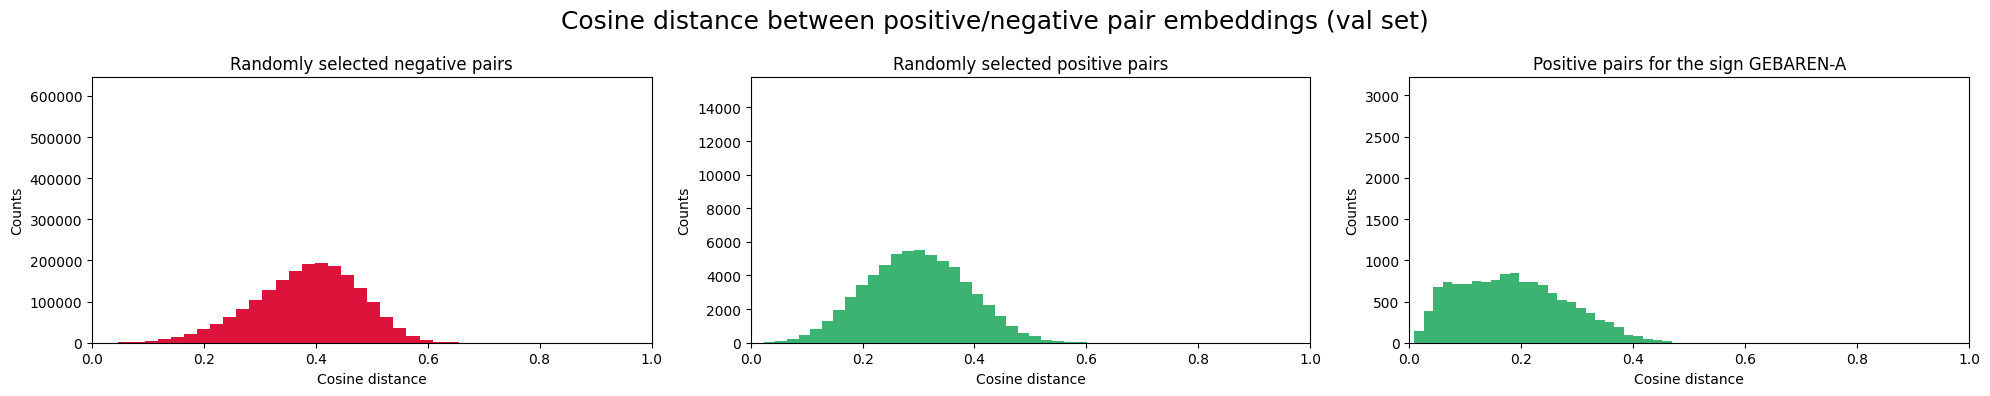

Epoch 8
1410/1410 [==============================] - 36s 22ms/step - loss: 0.5084 - val_loss: 0.4951
Ratio of randomly selected negative pairs >= 0.5: 0.172
Ratio of randomly selected positive pairs <= 0.5: 0.971
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


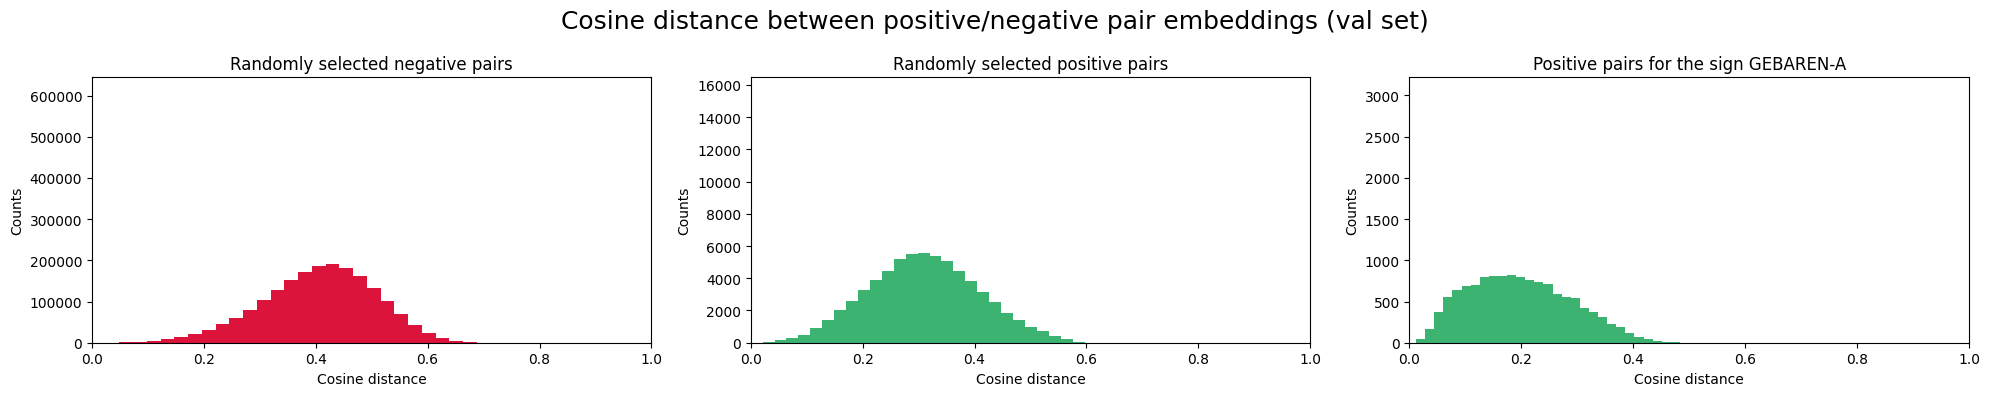

Epoch 9
1410/1410 [==============================] - 35s 21ms/step - loss: 0.5045 - val_loss: 0.4924
Ratio of randomly selected negative pairs >= 0.5: 0.161
Ratio of randomly selected positive pairs <= 0.5: 0.981
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


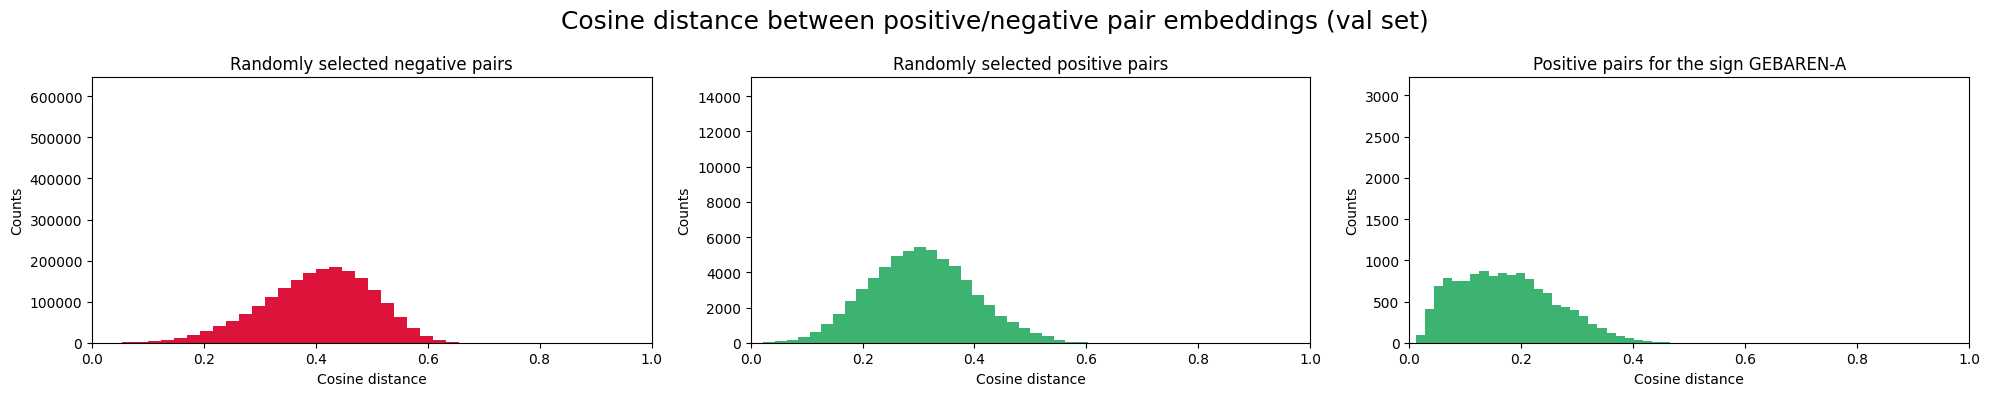

Epoch 10
1410/1410 [==============================] - 35s 21ms/step - loss: 0.4979 - val_loss: 0.4867
Ratio of randomly selected negative pairs >= 0.5: 0.171
Ratio of randomly selected positive pairs <= 0.5: 0.98
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


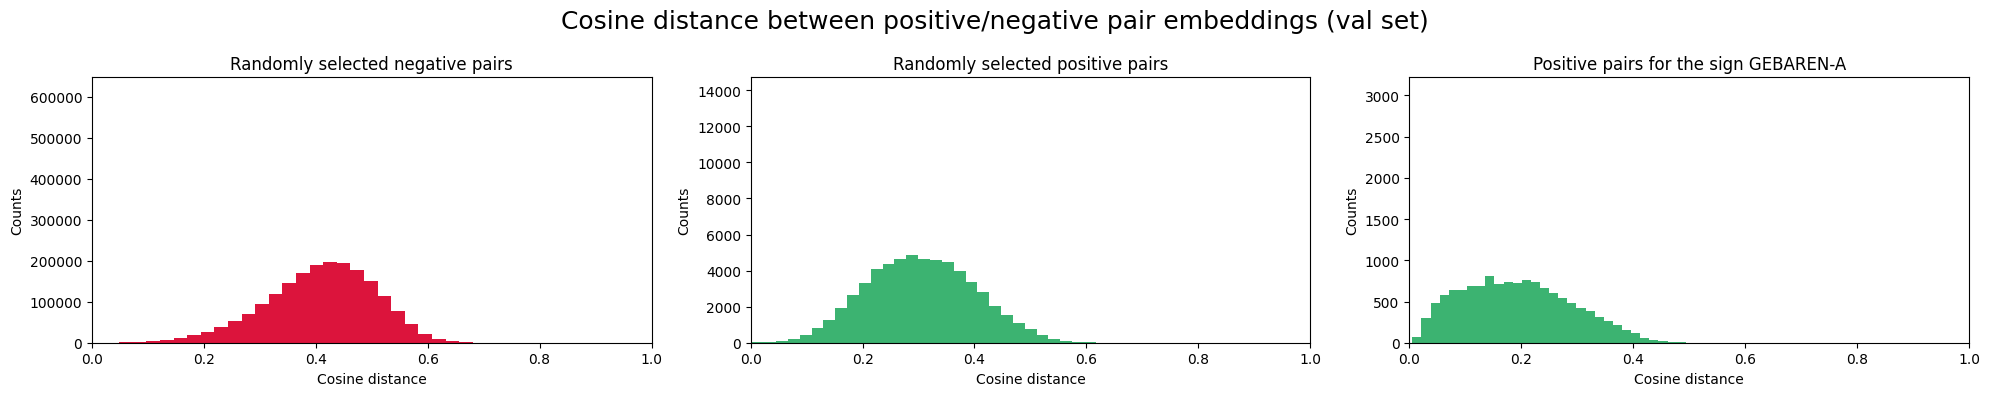

CPU times: total: 12min 28s
Wall time: 7min 48s


In [11]:
%%time
# Note: for each epoch, we plot a sample from the validation set in terms of the cosine distances of its embeddings
# This consists of three subplots: one for all the negative pairs in the sample, where we compare two different signs
# One for positive pairs random embeddings in the sample, where we compare embeddings of the same sign
# And lastly, positive pairs for specifically a common sign (GEBAREN-A) in the data
# DISCLAIMER: the x-axis has the same scale for each subplot but the y-axis does NOT!
num_epochs = 10
val_losses, train_losses = train_model(model, train_batch_gen, val_batch_gen, X_train, y_train, X_val, y_val, labels,
                                       target_num_label, batch_size, learning_rate, temperature, num_epochs = num_epochs, 
                                       decay_rate = num_epochs, ws = ws, num_classes = num_classes, patience = 3)

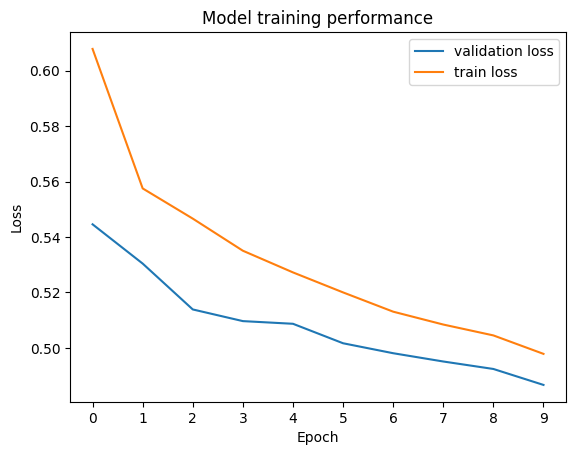

In [12]:
# Plotting the results
plt.title('Model training performance')
plt.plot(val_losses, label = 'validation loss')
plt.plot(train_losses, label = 'train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(val_losses)))
plt.legend()
plt.show()

Counts within test: [('PT-1hand', '1993 (int label)', 1057), ('PO', '1941 (int label)', 1001), ('PT-1hand:1', '1994 (int label)', 908), ('GEBAREN-A', '828 (int label)', 144), ('PO+PT', '1942 (int label)', 51), ('GOED-A', '914 (int label)', 100), ('KUNNEN-A', '1335 (int label)', 64), ('HOREN-A', '1097 (int label)', 82), ('ATTENTIE', '222 (int label)', 98), ('WETEN-A', '2770 (int label)', 62)]
Examples: (400, 10, 84)
Prediction result shape: (400, 256)


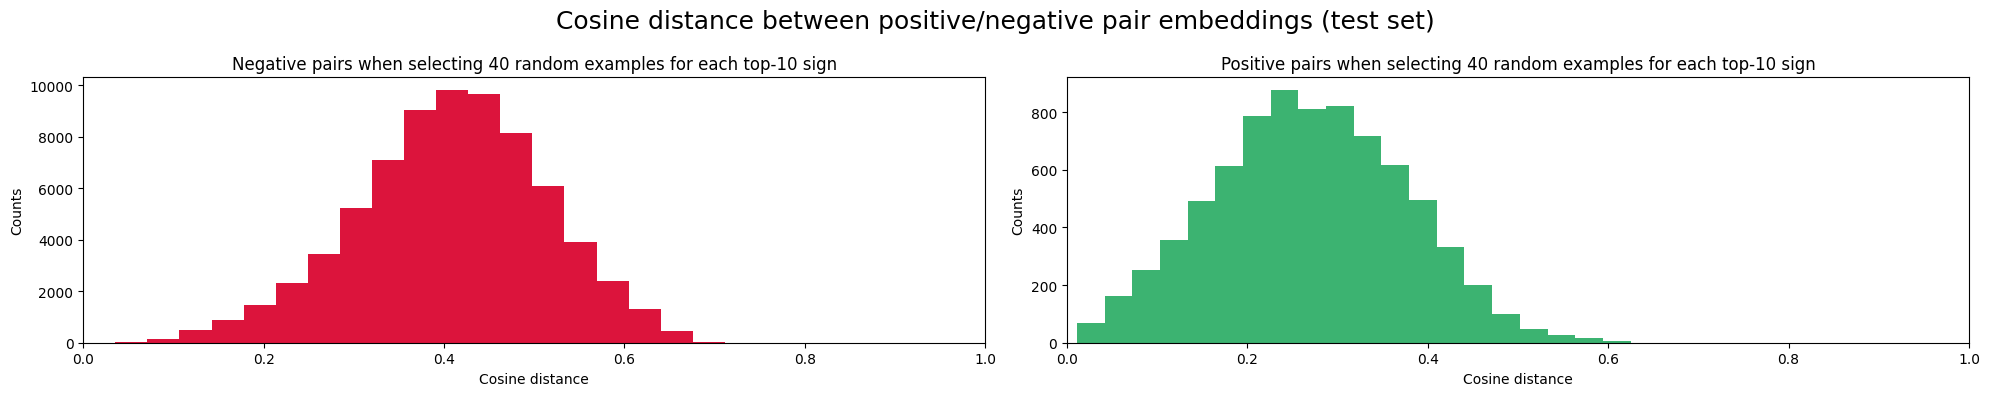

In [13]:
# We take 40 random signs for each of the top 10 most common signs
y_train_counts = sorted(Counter(y_train).items(), key = lambda x: x[-1], reverse = True)
common_sign_sample = []
y_test_top_counts = []
for label, count in y_train_counts[:10]:
    label_inds = np.where(y_test == label)[0]
    str_label = find_target_label(label, labels)[0]
    y_test_top_counts.append((str_label,str(label) + ' (int label)', len(label_inds)))
    label_sample = np.random.choice(label_inds, 40, replace = False)
    common_sign_sample += label_sample.tolist()
print('Counts within test:', y_test_top_counts)
pos_cosines, neg_cosines = compute_cosines(model, common_sign_sample, X_test, y_test)    
    
# Use subplots to plot them next to each other
fig, ax = plt.subplots(1, 2, figsize=(20,4))
fig.suptitle('Cosine distance between positive/negative pair embeddings (test set)', fontsize = 18)
# Random negative pairs
ax[0].hist(neg_cosines, bins = 20, color = 'crimson') # density = True, cumulative = True
ax[0].set_title('Negative pairs when selecting 40 random examples for each top-10 sign')
# Random positive pairs
ax[1].hist(pos_cosines, bins = 20, color = 'mediumseagreen') # density = True, cumulative = True
ax[1].set_title('Positive pairs when selecting 40 random examples for each top-10 sign')
for a in ax:
    a.set_xlim(0,1)
    a.set_ylabel('Counts')
    a.set_xlabel('Cosine distance')
#     a.set_yscale('log')
#     a.set_ylim(1, 10**5)
plt.tight_layout()
plt.show()

In [14]:
%%time
# Plot the distances between the embeddings of the test set
# plot_sim_of_sampled_embds(model, X_test, y_test, target_num_label, labels, num_samples = y_test.shape[0], log = True)

CPU times: total: 0 ns
Wall time: 0 ns


In [15]:
# Getting the counts of each label in the train set, then checking how many labels only occur once
train_label_counts = sorted(Counter(y_train).items(), key = lambda x: x[-1], reverse = True)
print('Num. unique labels in train set:', len(train_label_counts), '\nNum. labels in train set only occuring once:',
      len([t for t in train_label_counts if t[-1] == 1]))

Num. unique labels in train set: 2712 
Num. labels in train set only occuring once: 0


# Creating reference embeddings

In [16]:
# We use only the non-mirrored, not augmented train data to make reference embeddings
y_train_labels = np.array(list(set(y_train_no_mirr)))

# Check here that the last dimension of X_train_no_mirr is the same as X_train!
# Otherwise, you may be using the wrong datasets together (i.e. completely different features)
print('Train data shape (no augmentation or mirroring):', X_train_no_mirr.shape)

Train data shape (no augmentation or mirroring): (90216, 10, 84)


In [17]:
%%time
# Create reference embeddings for all the signs
reference_sign_embds = ref_embds(model, X_train_no_mirr, y_train_no_mirr, y_train_labels, top_ratio = 0.1)

CPU times: total: 4min 35s
Wall time: 3min 59s


# Ranking

In [18]:
%%time
# Show the acc@k for the test set annotations (k = 30, 20, 10 and 5 tested)
# We find how often the train-learned reference embedding is ranked in the top-k most similar embeddings
# Compared to a test embedding of the same sign
X_test_pred = model.predict(X_test, verbose = 0)
top_k_ranking_acc(reference_sign_embds, X_test_pred, y_test, y_train_labels, k_vals = [30,20,10,5])

Number of target signs ranked in top 30: 4734/9585
accuracy@30: 49.39%
Number of target signs ranked in top 20: 4248/9585
accuracy@20: 44.32%
Number of target signs ranked in top 10: 3463/9585
accuracy@10: 36.13%
Number of target signs ranked in top 5: 2668/9585
accuracy@5: 27.84%
CPU times: total: 35.9 s
Wall time: 36.7 s


# Sliding window example

In [19]:
# Get the reference embedding for our common sign example (e.g. 'GEBAREN-A')
reference_res = reference_sign_embds[target_num_label]

In [20]:
%%time
# Get the embedding of an entire target video
target_video = 'S053_CNGT1206.eaf' #'S011_CNGT0215' #'S002_CNGT0092'
print('Corpus target video:', target_video)  
# Get the embedding of each video in the test set using a sliding window
anns, video_embd_dict = make_test_video_embds(model, only_lmrks, select_video = target_video)

Corpus target video: S053_CNGT1206.eaf
Loading annotations and getting test video ids...
Loading test video features...
Done.                                                                                                    
CPU times: total: 6.77 s
Wall time: 19.9 s


In [21]:
# Get video embedding of the target video
result = video_embd_dict[target_video]
anns_dict = anns[target_video]
# Compute the distance of our target sign's reference embedding over the entire target video
dist = cdist(result, reference_res.reshape(1,-1), metric = 'cosine').flatten()

In [22]:
# Get the length of the target video in milliseconds
# We add +3 seconds because the Corpus videos start with a 3 second disclaimer
max_ms = int((3+result.shape[0]/25)*1000)

# Find where the target occurs in the video
if target_label[0] in anns_dict:
    target_times = anns_dict[target_label[0]]
    target_times = list(set(target_times))
    print('Found target times for {}: {}'.format(target_label[0], target_times))
else: # If the target sign is not present, we give out a warning
    print('Warning: target sign {} does not occur in corpus video {}'.format(target_label[0], target_video))
    target_times = []
# target_times.append((-1, -1))

Found target times for GEBAREN-A: [(224920, 225880), (278520, 278760)]


Frame with smallest distance: 5807 (timestamp 0:03:55)
Video: S053_CNGT1206.eaf


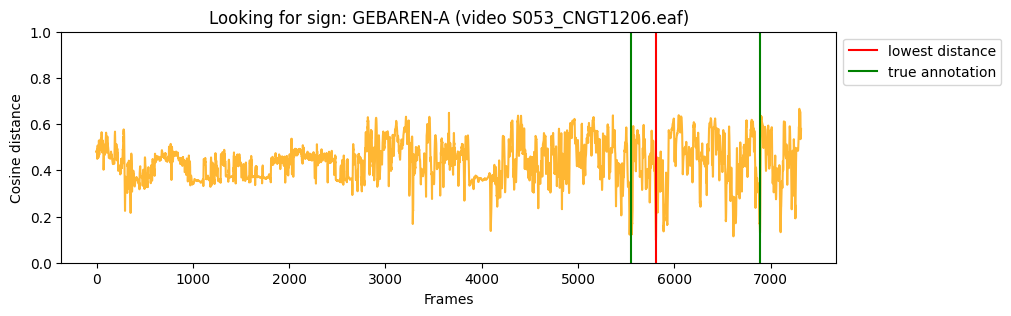

Annotation #1 of GEBAREN-A: 0:03:45-0:03:46
target frames: (5548, 5572)


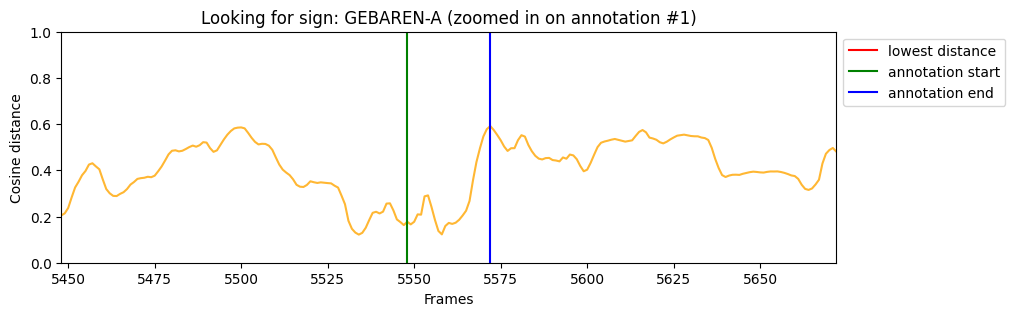

Annotation #2 of GEBAREN-A: 0:04:39-0:04:39
target frames: (6888, 6894)


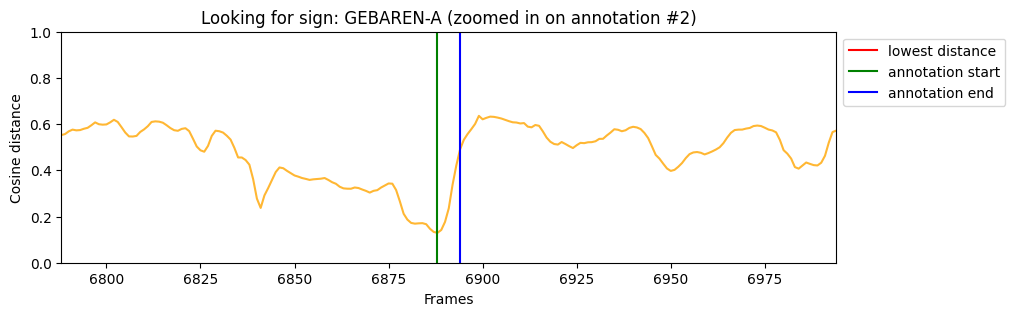

In [23]:
# Setting some default plotting settings that apply both for zoomed out and zoomed in plots
def default_plot_settings(dist, target_sign, title_str, xlim = None, ):
    plt.figure(figsize=(10,3))
    title = 'Looking for sign: ' + target_sign + ' ' + title_str
    plt.title(title)
    # Plot the distances
    plt.plot(dist, color = '#FFA500', alpha = 0.8)
    plt.ylim(0,1)
    # Add line at minimum distance
    plt.axvline(x = np.argmin(dist), color = 'r', label = 'lowest distance')    
    
    if xlim: 
        plt.xlim(xlim[0], xlim[1]) 

#Draw lines at the start and end of each labeled instance of the target sign
window = 100

# Get where the distance is minimal, draw a line there
min_dist = np.argmin(dist)
min_dist_sec = round(3+min_dist/25) # Convert to seconds
print('Frame with smallest distance: {} (timestamp {})'.format(min_dist, sec_to_timestamp(min_dist_sec)))

print('Video:', target_video)

# First, we plot the full video
default_plot_settings(dist, target_label[0], '(video {})'.format(target_video))
for i, target_time in enumerate(target_times):
    # Convert the target times to frames, plot their starting times
    target_frames = (ms_to_frame(target_time[0]), ms_to_frame(target_time[1]))
    # We only add a label for the first ann so the legend doesn't list the same thing multiple times
    plt.axvline(x = target_frames[0], color = 'g', label = 'true annotation' if i == 0 else None)
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 
plt.xlabel('Frames')
plt.ylabel('Cosine distance')
plt.show()

# Zooming in on specific annotations
for i, target_time in enumerate(target_times):
    # Get the start and end timestamps
    start_ts, end_ts = sec_to_timestamp(round(target_time[0]/1000)), sec_to_timestamp(round(target_time[1]/1000))
    print('Annotation #{} of {}: {}-{}'.format(i+1, target_label[0], start_ts, end_ts))

    # Convert the target times to frames, plot their starting times *and* ending times
    target_frames = (ms_to_frame(target_time[0]), ms_to_frame(target_time[1]))
    xlim = (max(0, target_frames[0]-window), min(max_ms, target_frames[1]+window)) 
    default_plot_settings(dist, target_label[0], '(zoomed in on annotation #{})'.format(i+1), xlim = xlim)
    
    print('target frames:', target_frames)
    # We zoom in on an annotation, adding lines where it's annotated
    plt.axvline(x = target_frames[0], color = 'g', label = 'annotation start')
    plt.axvline(x = target_frames[1], color = 'b', label = 'annotation end')
#     plt.xlim(xlim[0], xlim[1]) 
    
    plt.legend(bbox_to_anchor=(1,1), loc="upper left") 
    plt.xlabel('Frames')
    plt.ylabel('Cosine distance')
    plt.show()

In [24]:
# Make sure the checkpoint folder exists, otherwise create it
if not os.path.exists(PATHS['checkpoint_root']):
    os.mkdir(PATHS['checkpoint_root'])

model_path = 'model_lmrks' if only_lmrks else 'model_linguistic'
# Save model (that trained using linguistic or landmark features) in checkpoint folder
model.save(PATHS[model_path])

INFO:tensorflow:Assets written to: ./model_checkpoints/model_lmrks\assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model_lmrks\assets


In [25]:
# Convert timestamps in milliseconds to frames
for i, video in enumerate(anns):
    print('video {}/{}'.format(i+1, len(list(anns.keys()))), end = '\r')
    ann = anns[video]
    for sign in ann:
        timestamps = ann[sign]
        frames = [(ms_to_frame(t[0]), ms_to_frame(t[1])) for t in timestamps]
        ann[sign] = frames

In [26]:
# Save reference embds in checkpoint folder
embedding_path =  'embedding_lmrks' if only_lmrks else 'embedding_linguistic' 
store_dict(PATHS[embedding_path], reference_sign_embds)

# Also save the video embeddings of the test set
video_embds_path = 'vid_embd_lmrks' if only_lmrks else 'vid_embd_linguistic'
store_dict(PATHS[video_embds_path], video_embd_dict)